<a href="https://colab.research.google.com/github/juyongkak/MLproject/blob/main/Y_NetCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Y - Network

Y - Network 는 동일한 입력을 CNN 의 왼쪽과 오른쪽 가지에 두번 사용한다. 
신경망은 concatenate 계층을 사용하여 결과를 결합한다. 
결합 연산인 concate 연결축을 따라 동일한 형상을 갖는 두개의 텐서를 연결해 하나의 텐서를 구성하는 것과 비슷하다. 

우선 Y - Network 의 가지에서 필터수를 두배로 늘려 MaxPooling2D() 층 다음에서 특징 맵 크기가 절반으로 줄어든 것을 보완한다.
또, 양쪽 가지의 커널 크기는 3으로 같지만 오른쪽 가지에서는 팽창률을 2로 적용한다. 크기가 3인 커널에 팽창률을 사용해 커널의 적용 범위를 
증가 시키면, 이 CNN 모델에서 오른쪽 가지가 다양한 특징 맵을 학습시킬 수 있다는 것이다.

여기에서 padding = 'same' 옵션을 사용해 팽창된 CNN을 사용할 때 텐서 차원이 음수가 되지 않게 만든다.

In [ ]:
import numpy as np

from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import concatenate
from tensorflow.keras.utils import plot_model

In [ ]:
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

In [ ]:
#레이블 수 계산
num_labels = len(np.unique(y_train))

#원-핫 벡터로 변환
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
#입력 이미지 Shape 재조정, 규격화
image_size = x_train.shape[1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
# 신경망 매개변수 입력
input_shape = (image_size,image_size,3)
batch_size =32
kernel_size = 3
n_filters = 32
dropout = 0.3

In [ ]:
# Y-Network 왼쪽 가지 작성
left_inputs = Input(shape=input_shape)
filters = n_filters

x = left_inputs

#Conv2D - Dropout - MaxPoling2D 3계층 구성
#계층이 지날 떄 마다 필터 개수를 두배로 증가시킴(32 - 64 - 128)
for i in range(3):
    x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              padding='same',
              activation='relu')(x)
    
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    
    filters *= 2

In [ ]:
#Y-Network 오른쪽 가지 작성
right_inputs = Input(shape=input_shape)
filters = n_filters

y = right_inputs

#Conv2D - Dropout - MaxPoling2D 3계층 구성
#계층이 지날 떄 마다 필터 개수를 두배로 증가시킴(32 - 64 - 128)
for i in range(3):
    y = Conv2D(filters=filters,
              kernel_size=kernel_size,
              padding='same',
              activation='relu',
              dilation_rate=2)(y)
    
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    
    filters *=2

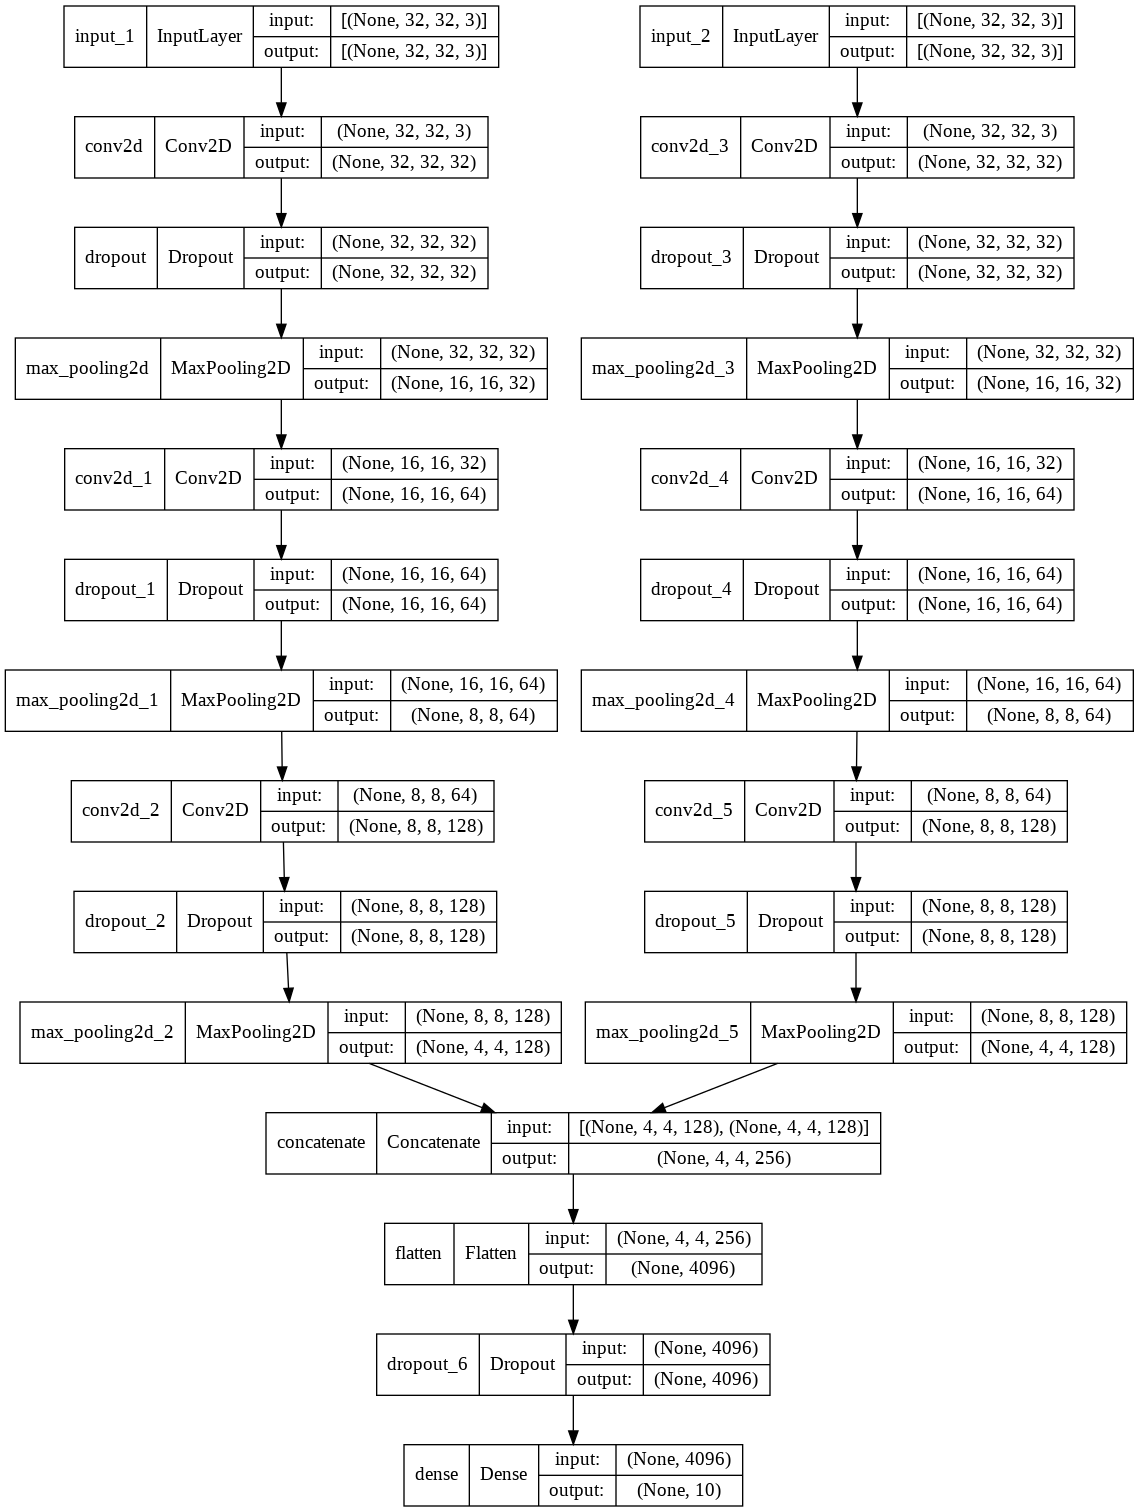

In [ ]:
# Y - Network 결합
y = concatenate([x,y])

# Dense 계층에 연결하기 전 특징 맵을 벡터로 변환
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

model = Model([left_inputs, right_inputs], outputs)
plot_model(model, to_file = 'cnn-y-network.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 32)   896         ['input_2[0][0]']                
                                                                                              

In [ ]:
#모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit([x_train, x_train], y_train, validation_data=([x_test, x_test], y_test), epochs=20, batch_size=batch_size)

Epoch 1/20
1563/1563 [==============================] - 284s 181ms/step - loss: 1.4340 - accuracy: 0.4846 - val_loss: 1.3437 - val_accuracy: 0.5586
Epoch 2/20
1563/1563 [==============================] - 283s 181ms/step - loss: 1.0739 - accuracy: 0.6223 - val_loss: 1.2427 - val_accuracy: 0.5930
Epoch 3/20
1563/1563 [==============================] - 284s 181ms/step - loss: 0.9455 - accuracy: 0.6688 - val_loss: 1.0750 - val_accuracy: 0.6493
Epoch 4/20
 280/1563 [====>.........................] - ETA: 3:41 - loss: 0.8563 - accuracy: 0.7027